
# SIEM Alert Data Exploration (EDA)

## Objective
This notebook performs exploratory data analysis (EDA) on raw SIEM alert logs.
The goal is to understand alert patterns, severity distribution, temporal behavior,
and potential indicators of malicious activity before feature engineering.

This step mimics how a SOC analyst investigates alert data prior to automation.


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


In [4]:
df = pd.read_csv("siem_alerts.csv")
df.head()


,timestamp,alert_type,source_ip,destination_host,user,failed_attempts,success_attempts,process_name,privilege_change,login_time,host_criticality,label
0,2024-02-02 12:00:00,MALWARE_EXEC,192.168.1.150,SERVER-8,alice,0,0,unknown.exe,0,day,medium,1
1,2024-01-16 11:10:00,MALWARE_EXEC,192.168.1.205,SERVER-8,bob,0,0,unknown.exe,0,day,medium,1
2,2024-02-02 10:36:00,PRIV_ESC,192.168.1.241,SERVER-5,alice,0,0,NaN,1,day,critical,1
3,2024-01-26 07:10:00,AUTH_FAILURE,192.168.1.139,SERVER-2,john,1,0,NaN,0,day,medium,1
4,2024-02-02 10:24:00,MALWARE_EXEC,192.168.1.57,SERVER-2,john,0,0,unknown.exe,0,day,critical,1


In [5]:

print("Dataset Shape:", df.shape)
df.info()


Dataset Shape: (2000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   timestamp         2000 non-null   object
 1   alert_type        2000 non-null   object
 2   source_ip         2000 non-null   object
 3   destination_host  2000 non-null   object
 4   user              2000 non-null   object
 5   failed_attempts   2000 non-null   int64 
 6   success_attempts  2000 non-null   int64 
 7   process_name      390 non-null    object
 8   privilege_change  2000 non-null   int64 
 9   login_time        2000 non-null   object
 10  host_criticality  2000 non-null   object
 11  label             2000 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 187.6+ KB


In [6]:

missing = df.isnull().sum()
missing[missing > 0]


,0
process_name,1610


In [7]:

df.describe(include="all")


,timestamp,alert_type,source_ip,destination_host,user,failed_attempts,success_attempts,process_name,privilege_change,login_time,host_criticality,label
count,2000,2000,2000,2000,2000,2000.000000,2000.000000,390,2000.00000,2000,2000,2000.000000
unique,1967,5,254,10,4,NaN,NaN,1,NaN,2,4,NaN
top,2024-02-04 11:52:00,PORT_SCAN,192.168.1.2,SERVER-6,bob,NaN,NaN,unknown.exe,NaN,day,medium,NaN
freq,2,429,18,212,514,NaN,NaN,390,NaN,1243,516,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.006500,0.197000,NaN,0.18750,NaN,NaN,0.549000
std,NaN,NaN,NaN,NaN,NaN,2.424334,0.397832,NaN,0.39041,NaN,NaN,0.497718
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.00000,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.00000,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.00000,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.00000,NaN,NaN,1.000000


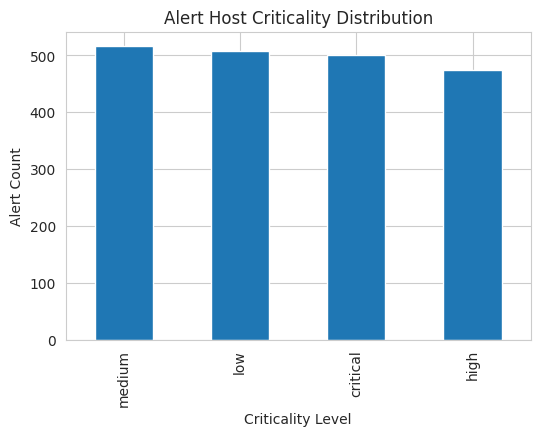

In [9]:
plt.figure(figsize=(6,4))
df["host_criticality"].value_counts().plot(kind="bar")
plt.title("Alert Host Criticality Distribution")
plt.xlabel("Criticality Level")
plt.ylabel("Alert Count")
plt.show()

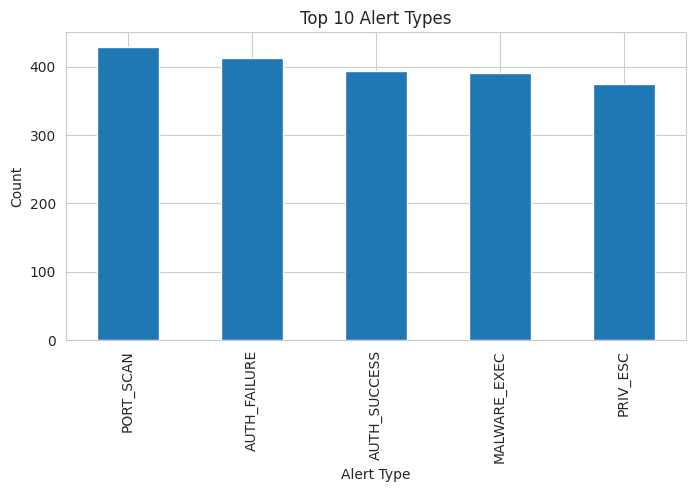

In [10]:
plt.figure(figsize=(8,4))
df["alert_type"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Alert Types")
plt.xlabel("Alert Type")
plt.ylabel("Count")
plt.show()


In [11]:
if "protocol" in df.columns:
    plt.figure(figsize=(6,4))
    df["protocol"].value_counts().plot(kind="bar")
    plt.title("Network Protocol Distribution")
    plt.show()


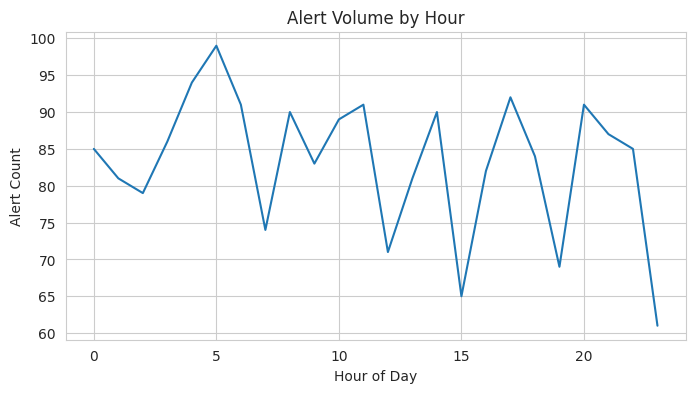

In [12]:
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df["hour"] = df["timestamp"].dt.hour

    plt.figure(figsize=(8,4))
    df["hour"].value_counts().sort_index().plot()
    plt.title("Alert Volume by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Alert Count")
    plt.show()


In [13]:
if "source_ip" in df.columns:
    df["source_ip"].value_counts().head(10)


In [14]:
if "destination_ip" in df.columns:
    df["destination_ip"].value_counts().head(10)


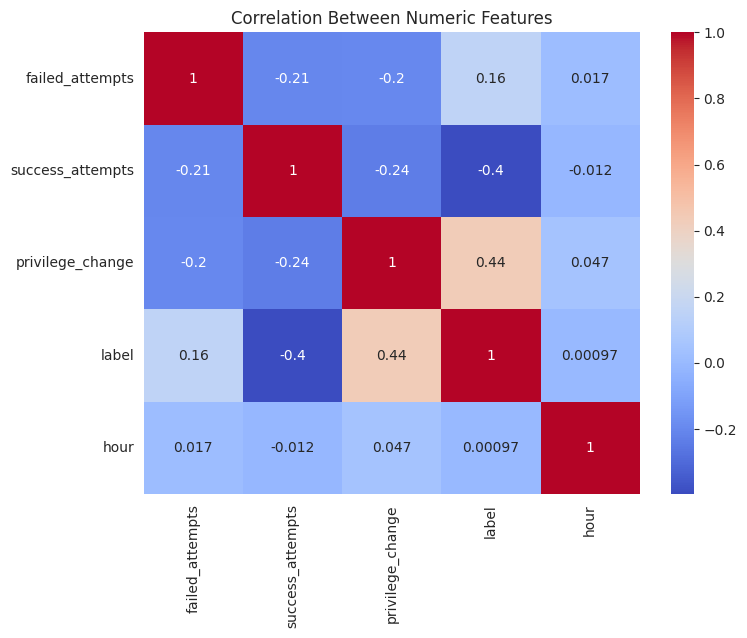

In [15]:
numeric_df = df.select_dtypes(include=np.number)

if not numeric_df.empty:
    plt.figure(figsize=(8,6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Between Numeric Features")
    plt.show()



## Key Observations

- SIEM alerts show imbalance across severity levels.
- Certain alert types occur disproportionately more often.
- Alert frequency varies by time, indicating possible automated activity.
- Some IP addresses trigger repeated alerts, suggesting malicious behavior.

These insights will guide feature engineering in the next notebook.
